## Packages

In [1]:
# Install arch library
!pip install arch
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 7.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.0 MB/s eta 0:00:00


In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from math  import sqrt
import seaborn as sns
from google.colab import drive
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import yfinance
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [70]:
raw_data = yfinance.download(tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2018-01-29", 
                             interval = "1d", group_by = "ticker", auto_adjust = True)

[*********************100%***********************]  4 of 4 completed


In [86]:
df_comp = raw_data.copy()

In [87]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [88]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

## Creating Returns

In [90]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

In [91]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [92]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [25]:
model_ar = ARIMA(df.ftse, order = (1, 0, 0))
results_ar = model_ar.fit()

## Simple Forecasting

In [11]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2013-04-01,1562.170044,7795.310059,6411.700195,12135.019531,-0.447358,0.000000,0.000000,-2.120443,186.507731,-0.000000,0.000000,-935.368371
2013-04-02,1570.250000,7943.870117,6490.700195,12003.429688,0.517226,1.232122,1.905762,-1.084381,-215.636502,-158.180337,1367.802234,-478.341386
2013-04-03,1553.689941,7874.750000,6420.299805,12362.200195,-1.054613,-1.084635,-0.870106,2.988900,439.677916,139.245809,-624.492133,1318.461488
2013-04-04,1559.979980,7817.390137,6344.100098,12634.540039,0.404845,-1.186856,-0.728402,2.203005,-168.783728,152.368996,-522.788437,971.787879
2013-04-05,1553.280029,7658.750000,6249.799805,12833.639648,-0.429490,-1.486425,-2.029324,1.575836,179.058193,190.827793,-1456.484709,695.131611


In [83]:
start_date = "2014-07-15"
end_date = "2015-01-01"

In [27]:
df_pred = results_ar.predict(start = start_date, end = end_date)

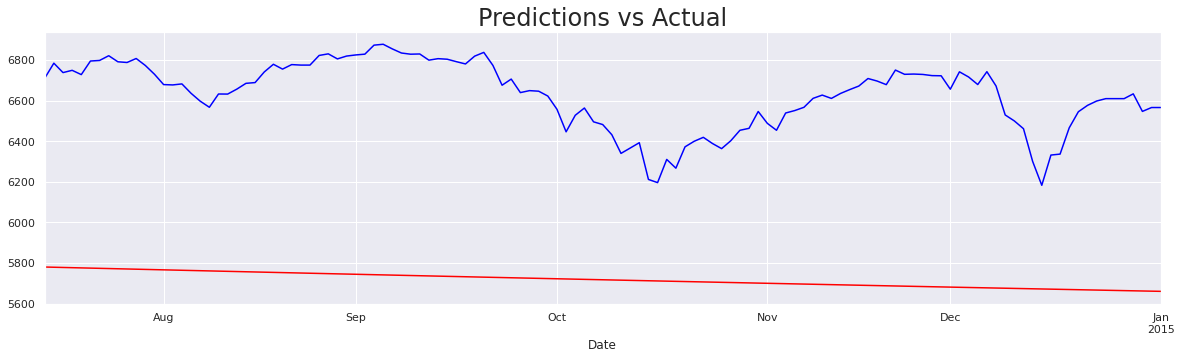

In [29]:
df_pred[start_date:end_date].plot(figsize = (20, 5), color = "red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

## Using Returns Instead

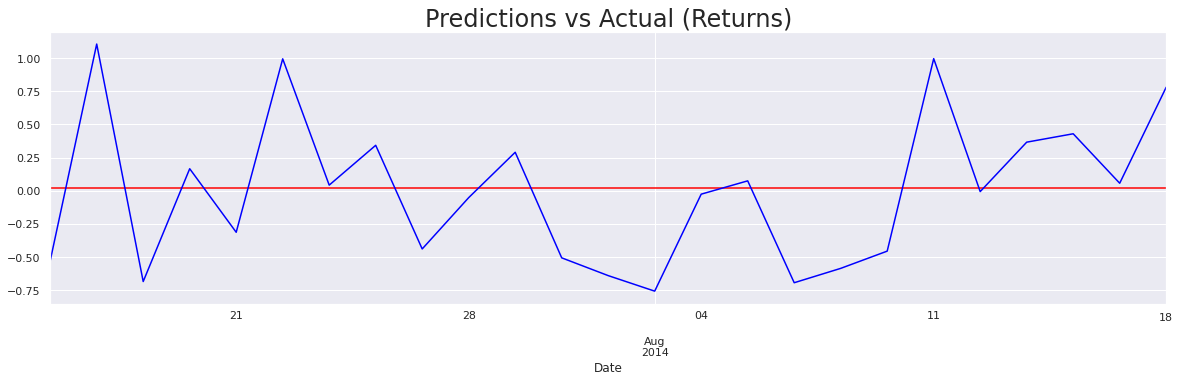

In [39]:
end_date = "2014-08-18"
model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5, 0, 0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date)

df_pred_ar[start_date:end_date].plot(figsize = (20, 5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

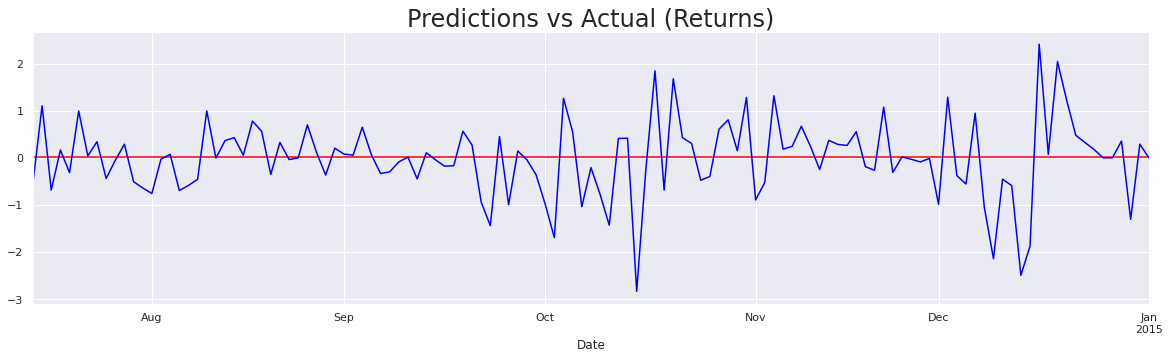

In [40]:
end_date = "2015-01-01"
model_ret_ma = ARIMA(df.ret_ftse[1:], order = (0, 0, 1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date)

df_pred_ma[start_date:end_date].plot(figsize = (20, 5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

## ARMA

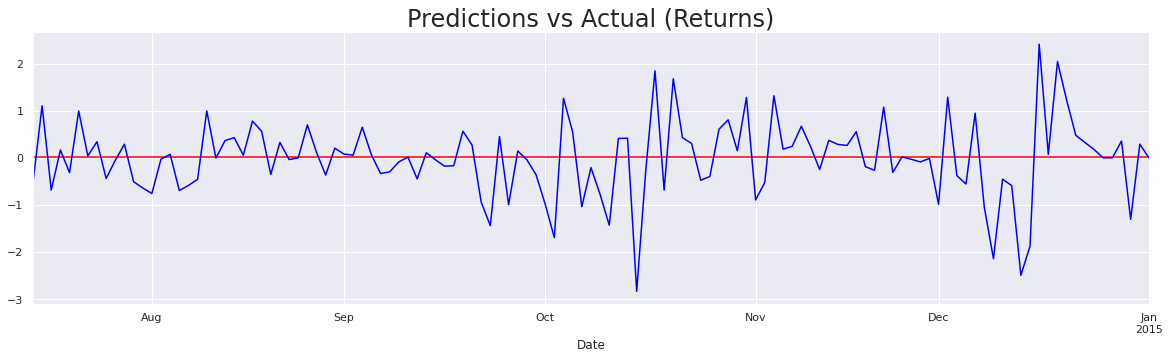

In [41]:
end_date = "2015-01-01"
model_ret_arma = ARIMA(df.ret_ftse[1:], order = (1, 0, 1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20, 5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [42]:
df_pred_arma.head()

2014-07-15    0.018935
2014-07-16    0.018935
2014-07-17    0.018935
2014-07-18    0.018935
2014-07-21    0.018935
Freq: B, Name: predicted_mean, dtype: float64

In [43]:
df_pred_arma.tail()

2014-12-26    0.018935
2014-12-29    0.018935
2014-12-30    0.018935
2014-12-31    0.018935
2015-01-01    0.018935
Freq: B, Name: predicted_mean, dtype: float64

## ARMAX

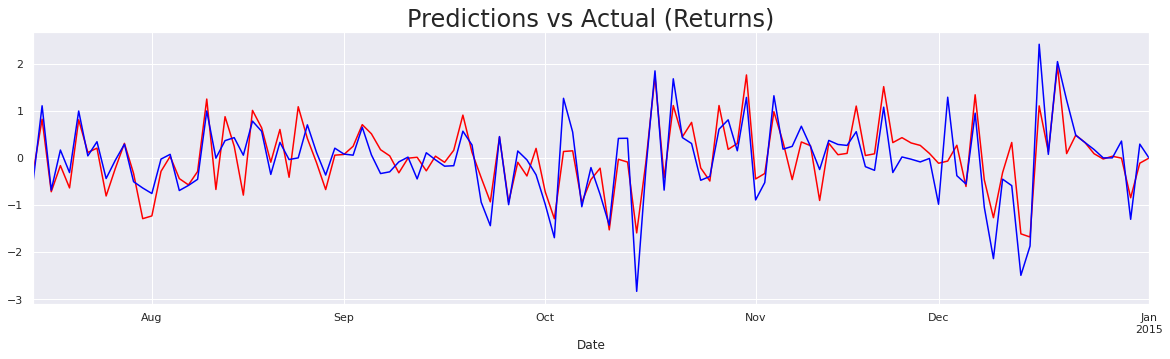

In [121]:
start_date = "2014-07-15"
end_date = "2015-01-01"

model_ret_armax = ARIMA(df.ret_ftse[1:], order = (1, 0, 1), exog = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:])
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = df_test.index[0], end=df_test.index[-1],
                                          exog = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']])

df_pred_armax[start_date: end_date].plot(figsize = (20, 5), color = "red")
df_test[start_date:end_date].ret_ftse.plot(color="blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

## SARMA

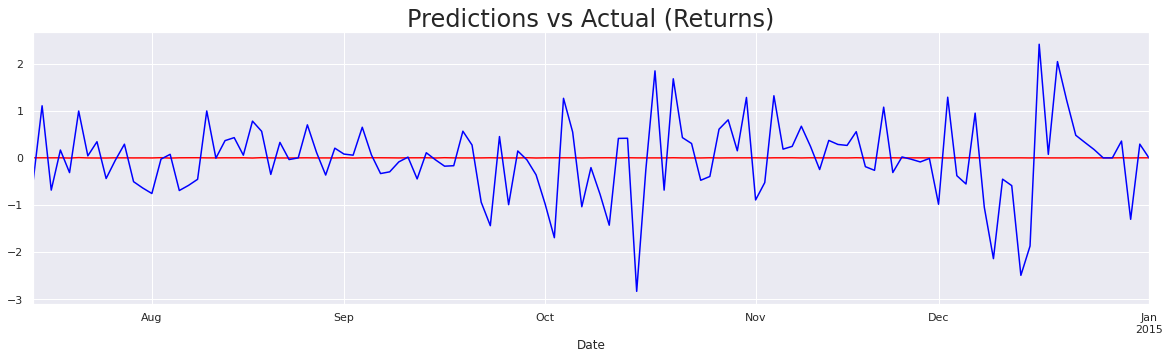

In [122]:
start_date = "2014-07-15"
end_date = "2015-01-01"

model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3, 0, 4), seasonal_order=(3, 0, 2, 5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date: end_date].plot(figsize = (20, 5), color = "red")
df_test[start_date:end_date].ret_ftse.plot(color="blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

## SARIMAX

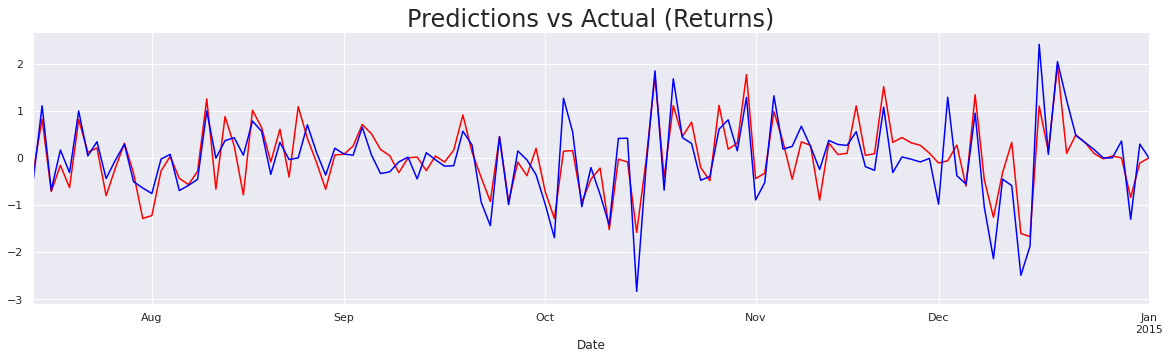

In [123]:
start_date = "2014-07-15"
end_date = "2015-01-01"

model_ret_sarimax = SARIMAX(df.ret_ftse[1:], order = (3, 0, 4), seasonal_order=(3, 0, 2, 5),
                          exog = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:])
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = df_test.index[0], end=df_test.index[-1],
                                          exog = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']])

df_pred_sarimax[start_date: end_date].plot(figsize = (20, 5), color = "red")
df_test[start_date:end_date].ret_ftse.plot(color="blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

## Auto ARIMA

In [124]:
model_auto = auto_arima(df.ret_ftse[1:])

In [182]:
# n_periods tells us how many elements we wanna predict
df_auto_pred = model_auto.predict(n_periods=len(df_test[start_date: end_date]))
index = df_test[start_date:end_date].index
df_auto_pred = pd.DataFrame({"":df_auto_pred, "index":index})
df_auto_pred = df_auto_pred.set_index("index")

In [183]:
df_auto_pred

,
index,
2014-07-15,0.224090
2014-07-16,0.050250
2014-07-17,0.098856
2014-07-18,0.038850
2014-07-21,0.127864
...,...
2014-12-26,0.000200
2014-12-29,-0.000085
2014-12-30,-0.000193


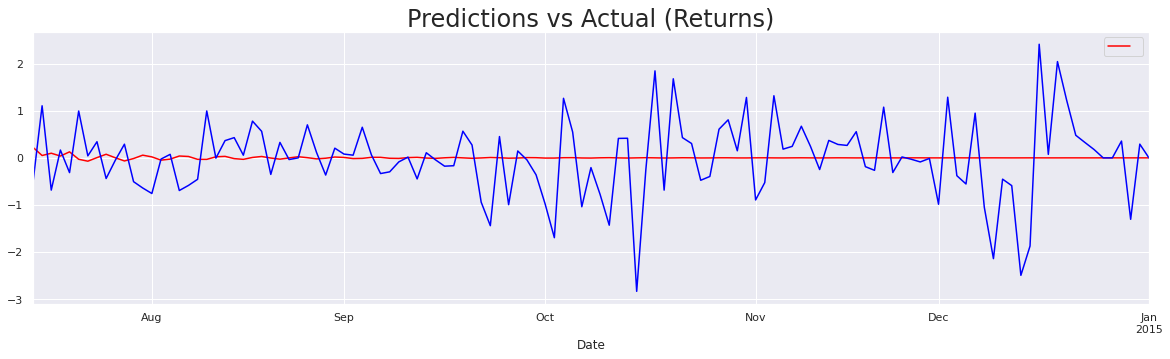

In [184]:
df_auto_pred[start_date: end_date].plot(figsize = (20, 5), color = "red")
df_test[start_date:end_date].ret_ftse.plot(color="blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

## Comparing All the Models (Returns)

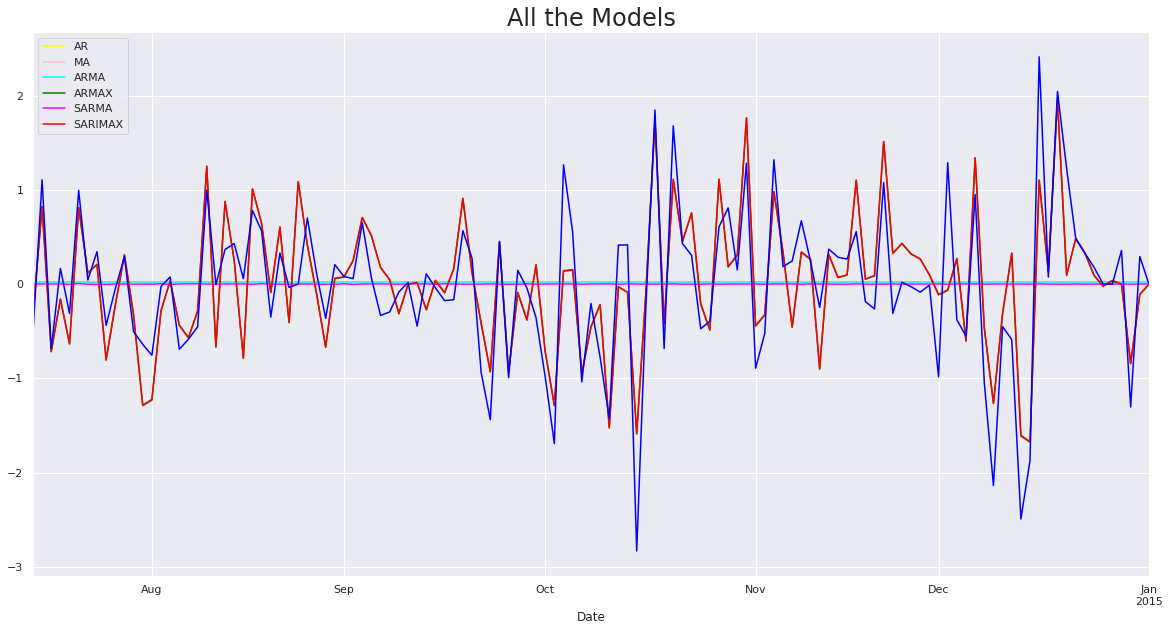

In [186]:
end_date="2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20, 10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR', 'MA', 'ARMA', 'ARMAX', 'SARMA', 'SARIMAX'])
plt.title("All the Models", size=24)
plt.show()

## Forecasting Volatility
- This is **one** of the ways we can go around this issue of missing exogenous variables

In [187]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)


Iteration:     10,   Func. Count:     65,   Neg. LLF: 7309.738663281408
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7309.738653886703
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


In [188]:
# horizon : how many observations we want our model to predict for each date
# align : determines whether we match the value with the date the prediction is made on, or it's supposed to represent
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

Our volatility predicitions aren't linear

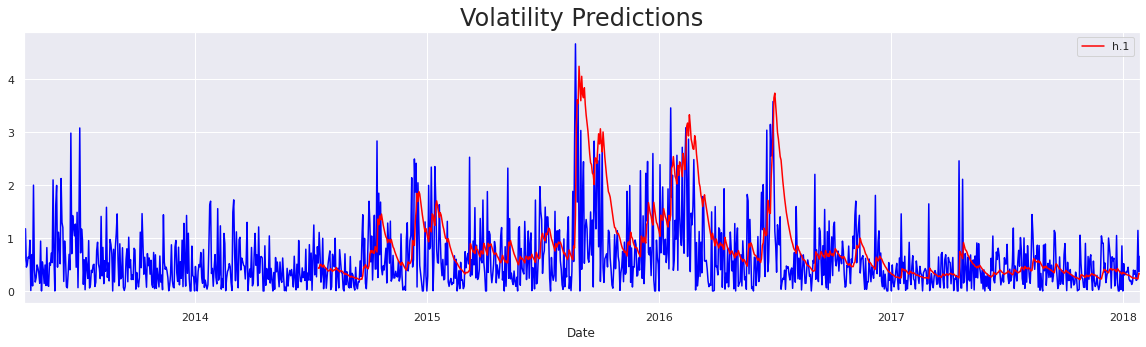

In [194]:
pred_garch.residual_variance[start_date:].plot(figsize = (20, 5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color="blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [195]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')


In [197]:
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,0.325666,0.339335,0.24341,0.259997,0.274505,0.284425,0.293391,0.29712,0.312694,0.330342,...,0.874867,0.891624,0.910146,0.927307,0.938552,0.904733,0.863216,0.872782,0.885312,0.892351


## Multivariate regression
Regressions stacked on top of one another

In [199]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [200]:
# 20 : maximum order of the model
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic="aic")

In [201]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Mar, 2023
Time:                     19:27:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.449050
Nobs:                     5014.00    HQIC:                  0.378098
Log likelihood:          -29226.2    FPE:                    1.40470
AIC:                     0.339820    Det(Omega_mle):         1.38141
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.035802         0.017040            2.101           0.036
L1.ret_spx           -0.112462         0.018140           -6.200           0.000
L1.ret_dax            0.064253         0.019679           

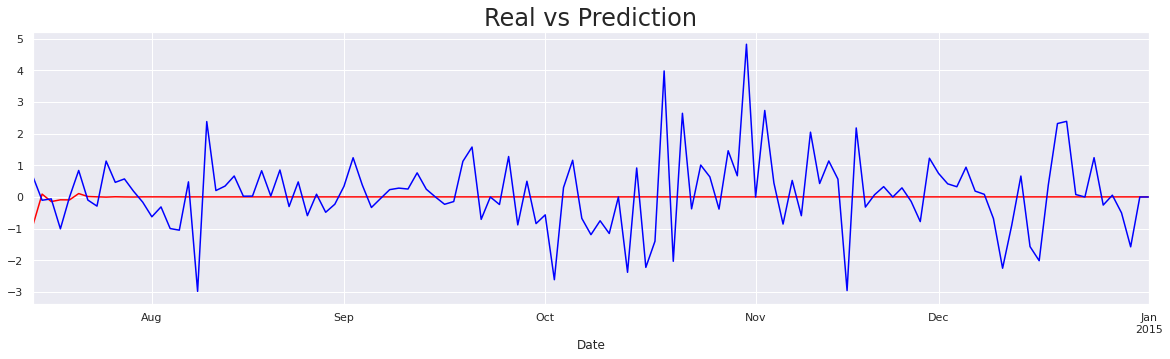

In [205]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data=var_pred_ret, index = df_test[start_date:end_date].index, columns = df_test[start_date:end_date].columns[4:8])
df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize=(20, 5), color='red')

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

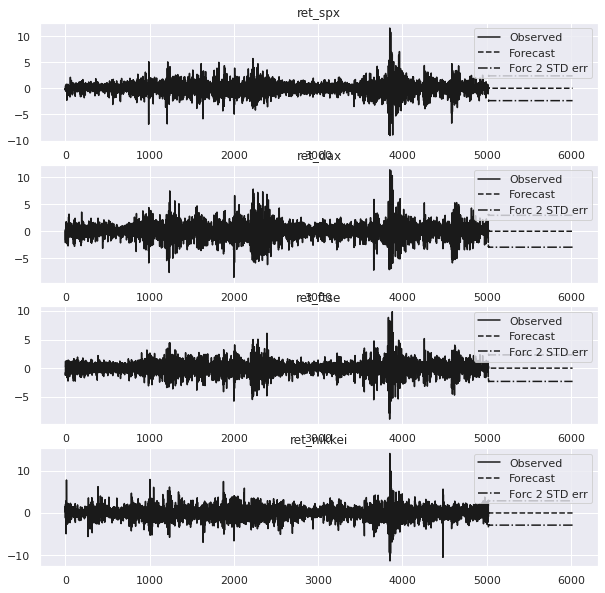

In [210]:
results_var_ret.plot_forecast(1000)
plt.show()